# Optimal Control

In [197]:
import control.optimal as obc
from control import flatsys

Consider the following optimal control problem:

Find the control that optimizes the following objective (cost): $\min_{u(t)} \int_{t_0}^{t_f} L(x,u)dt $

subject to the dynamic constraints: $\dot{x}=f(x,u)$

and any additional constraints: $lb_i \leq g_i(x,u) \leq ub_i$ 

This optimal control problem can be solved using the `obc.solve_ocp(sys,horizon,X0,cost,constraints)` function

## Brachistochrone Problem

$\min t_f$

subject to $\dot{x}=v\sin u, \quad (x(0),x(t_f))=(0,2) \\ \dot{y}=v\cos u, \quad (y(0),y(t_f))=(0,2) \\ \dot{v}=g\cos u, \quad (v(0),v(t_f))=(0,Free)$

`sys` parameter is an `InputOutputSystem` object

In [198]:
def model_update(t, z, u, params):
    g = params.get('g',10.)
    
    # Define state variables
    x = z[0]
    y = z[1]
    v = z[2]
    t = z[3] # include t as a state since the transformed problem is on [0,1]
    
    # Define control variables
    th = u[0]
    tf = u[1] # tf is included as a control variable since the final time is unknown
    
    xdot = (v * np.sin(u[0])) * tf
    ydot = (v * np.cos(u[0])) * tf
    vdot = (g * np.cos(u[0])) * tf
    tdot = tf
    
    return np.array([xdot, ydot, vdot, tdot])

def model_output(t, z, u, params):
    return z
    
model = ct.NonlinearIOSystem(model_update, model_output,
                             states=4, name='brachistochrone',
                             inputs=('th','tf'), outputs=('x','y','v','t'))
model

<NonlinearIOSystem:brachistochrone:['th', 'tf']->['x', 'y', 'v', 't']>

`obc.quadratic_cost` used to create a quadratic cost function: $\int (\mathbf{x}^T \mathbf{Qx} + \mathbf{u}^T \mathbf{Ru})dt$ 

In [199]:
Q = np.diag(np.zeros(4))
R = np.diag(np.zeros(2))

traj_cost = obc.quadratic_cost(model, Q, R)
traj_cost

<function control.optimal.quadratic_cost.<locals>.<lambda>(x, u)>

Cost functions can also be defined with a user-defined function, called as `cost_function(x,u)`

In [200]:
term_cost = lambda z, u: z[3] # tf

Next we define our problem bounds. It is best practice to provide bounds for all variables.

In [201]:
# Define problem bounds
x0 = 0.; xf = 2.
y0 = 0.; yf = 2.
v0 = 0.; vf = None
t0 = 0.; tf = None

xlb = -10.; xub = 10.
ylb = -10.; yub = 10.
vlb = -10.; vub = 10.
tlb = 0.;   tub = 10.

thlb = 0.; thub = 10.
tflb = 0.; tfub = 10.

z0 = [x0, y0, v0, t0]

Next we define our constraints. The `optimal` module provides several functions for this, such as `input_range_constraint()` and `state_range_constraint`, but constraints can also be made with user-defined functions. The syntax is `(scipy.optimize.LinearConstraint,A,lb,ub)` or `(scipy.optimize.NonlinearConstraint,fun,lb,ub)`. The constraints are then passed as a list of tuples.

In [202]:
input_bounds = obc.input_range_constraint(model, [thlb,tflb], [thub,tfub])
state_bounds = obc.state_range_constraint(model, [xlb,ylb,vlb,tlb], [xub,yub,vub,tub])

traj_constraints = [ input_bounds, state_bounds ]
traj_constraints

[(scipy.optimize._constraints.LinearConstraint,
  array([[0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 1.]]),
  array([0., 0.]),
  array([10., 10.])),
 (scipy.optimize._constraints.LinearConstraint,
  array([[1., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0.]]),
  array([-10., -10., -10.,   0.]),
  array([10., 10., 10., 10.]))]

In [203]:
from scipy.optimize import NonlinearConstraint

term_state = obc.state_range_constraint(model, [xf,yf,vlb,tlb], [xf,yf,vub,tub]) # xf and yf are fixed, vf is free, and tf is unknown

term_time = (NonlinearConstraint, lambda z,u: z[3] - u[1], 0.,0.) # Constraining the tf state variable with the tf control variable

term_constraints = [ term_state, term_time ]
term_constraints

[(scipy.optimize._constraints.LinearConstraint,
  array([[1., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0.]]),
  array([  2.,   2., -10.,   0.]),
  array([ 2.,  2., 10., 10.])),
 (scipy.optimize._constraints.NonlinearConstraint,
  <function __main__.<lambda>(z, u)>,
  0.0,
  0.0)]

Define the horizon over which to solve the problem. For this problem, we transformed the original time horizon from $[t_0,t_f]$ to $[0,1]$.

In [204]:
horizon = np.linspace(0, 1, 10, endpoint=True)

Finally, we can call `solve_ocp` to solve our optimal control problem.

In [212]:
result = obc.solve_ocp(model, horizon, z0, 
                       cost=traj_cost, terminal_cost=term_cost, 
                       trajectory_constraints=traj_constraints,
                       terminal_constraints=term_constraints,
                       initial_guess=[1.,1.])

Summary statistics:
* Cost function calls: 2271
* Constraint calls: 4765
* Eqconst calls: 2393
* System simulations: 8613
* Final cost: 0.81706279145248


/opt/anaconda3/lib/python3.8/site-packages/control/optimal.py:862: UserWarning: unable to solve optimal control problem
scipy.optimize.minimize returned Iteration limit reached
  warnings.warn(


As a blackbox function, `optimal` does not require much understanding of optimal control to pose an optimal control problem. However, it also offers very little customization of the numerical methods used to solve the problem. Therefore, it can be difficult to achieve convergence, as noted in the documentation. Some tips for trying to achieve convergence:
- Try using a smaller number of time points in your horizon (prevents the problem from growing too large)
- Use smooth basis functions (instead of the default which parameterizes the control at each time point)
- Tweak the optimizer options (see `scipy.optimize.minimize()` for accepted kwargs)

In [213]:
result = obc.solve_ocp(model, horizon, z0, 
                       cost=traj_cost, terminal_cost=term_cost, 
                       trajectory_constraints=traj_constraints,
                       terminal_constraints=term_constraints,
                       initial_guess=[1.,1.],
                       basis=flatsys.PolyFamily(2),
                       minimize_method='SLSQP',
                       minimize_options={'eps': 0.1})

Summary statistics:
* Cost function calls: 781
* Constraint calls: 1685
* Eqconst calls: 845
* System simulations: 1661
* Final cost: 0.8164701258850586


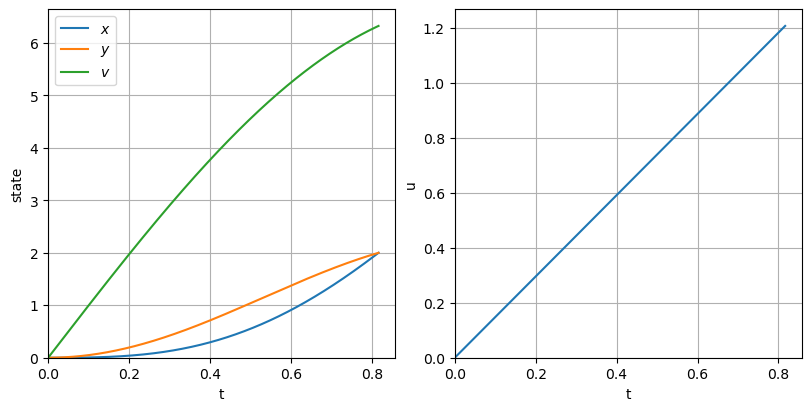

In [214]:
resp = ct.input_output_response(model, horizon, result.inputs, z0,
                                t_eval=np.linspace(0, 1, 1000)) # Resample our result using a denser grid
t, z, u = resp.time, resp.outputs, resp.inputs

t = z[3] 

fig, axs = plt.subplots(1, 2, figsize=(8,4), layout='constrained')
axs[0].plot(t, z[0],label=r'$x$')
axs[0].plot(t, z[1],label=r'$y$')
axs[0].plot(t, z[2],label=r'$v$')
axs[0].set_xlabel("t")
axs[0].set_ylabel("state")
axs[0].legend()

axs[1].plot(t, u[0],label=r'$u$')
axs[1].set_xlabel("t")
axs[1].set_ylabel("u")

for ax in axs:
    ax.set_xlim(0)
    ax.set_ylim(0)
    ax.grid(True)